In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('candidate_variables.csv')

In [3]:
data.shape

(96397, 317)

In [4]:
data.head()

,rec,date,card_#days_since,card_lag0_benford,card_lag0_cnt,card_lag0_avg,card_lag0_max,card_lag0_med,card_lag0_tot,card_lag0_act_avg,...,card_state_lag30_med,card_state_lag30_tot,card_state_lag30_act_avg,card_state_lag30_act_max,card_state_lag30_act_med,card_state_lag30_act_tot,card_benford,merch_benford,weekday_risk,fraud
0,1,2010-01-01,0.0,1.000000,1,3.62,3.62,3.62,3.62,1.0,...,3.62,3.62,1.0,1.0,1.0,1.0,1.000000,1.000000,0.025994,0
1,2,2010-01-01,0.0,1.000894,1,31.42,31.42,31.42,31.42,1.0,...,31.42,31.42,1.0,1.0,1.0,1.0,1.000894,1.000894,0.025994,0
2,3,2010-01-01,0.0,1.000894,1,178.49,178.49,178.49,178.49,1.0,...,178.49,178.49,1.0,1.0,1.0,1.0,1.000894,1.000894,0.025994,0
3,4,2010-01-01,0.0,1.000000,1,3.62,3.62,3.62,3.62,1.0,...,3.62,3.62,1.0,1.0,1.0,1.0,1.000000,1.000000,0.025994,0
4,5,2010-01-01,0.0,1.000000,2,3.62,3.62,3.62,7.24,1.0,...,3.62,7.24,1.0,1.0,1.0,0.5,1.000000,1.000000,0.025994,0


### Capping and Scaling

In [5]:
# remove first two weeks of data and drop record & date
var = data[data['date']>'2010-01-14']
labels = var['fraud']
dates = var['date']
var = var.drop(columns=['rec','date','fraud'])

In [6]:
var.shape

(93059, 314)

In [7]:
var_mod = var[dates.values<'2010-11-01'].copy()
var_oot = var[dates.values>='2010-11-01'].copy()
print('Modeling data:', var_mod.shape)
print('OOT data:', var_oot.shape)

Modeling data: (80632, 314)
OOT data: (12427, 314)


In [8]:
# standardize all variables
scaler = StandardScaler()
scaledVarMod = scaler.fit_transform(var_mod)
scaledVarOOT = scaler.transform(var_oot)
scaledVarMod = pd.DataFrame(scaledVarMod)
scaledVarOOT = pd.DataFrame(scaledVarOOT)
scaledVarMod.columns = var.columns
scaledVarOOT.columns = var.columns

In [9]:
scaledVarMod.describe()

,card_#days_since,card_lag0_benford,card_lag0_cnt,card_lag0_avg,card_lag0_max,card_lag0_med,card_lag0_tot,card_lag0_act_avg,card_lag0_act_max,card_lag0_act_med,...,card_state_lag30_max,card_state_lag30_med,card_state_lag30_tot,card_state_lag30_act_avg,card_state_lag30_act_max,card_state_lag30_act_med,card_state_lag30_act_tot,card_benford,merch_benford,weekday_risk
count,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,...,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04
mean,8.459681e-18,2.552004e-16,-1.409947e-18,-3.383873e-17,3.524867e-17,5.921777e-17,3.524867e-18,4.458076e-16,6.344761e-17,8.988411e-18,...,-2.255915e-17,2.819894e-17,-2.960888e-17,6.943988e-17,2.157219e-16,1.533317e-17,-1.691936e-16,-3.207629e-17,1.127958e-17,-4.511830e-17
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,...,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-3.184767e-01,-5.208406e-02,-2.440676e-01,-5.403616e-01,-4.779187e-01,-5.296049e-01,-2.068281e-01,-2.245385e+00,-3.088856e+00,-1.407685e-01,...,-5.497304e-01,-5.240831e-01,-3.123113e-01,-1.299820e+00,-1.655411e+00,-3.092730e-01,-1.162309e+00,-2.812419e-01,-1.120571e-01,-7.792001e-01
25%,-3.184767e-01,-5.038086e-02,-2.440676e-01,-4.854640e-01,-4.343012e-01,-4.794301e-01,-1.909533e-01,-4.921536e-03,4.421905e-01,-4.221796e-02,...,-4.841552e-01,-4.568021e-01,-2.808229e-01,-5.253711e-01,-1.081458e+00,-1.123697e-01,-9.903851e-01,-2.400041e-01,-1.118479e-01,-4.065420e-01
50%,-2.581101e-01,-5.038086e-02,-2.440676e-01,-3.230790e-01,-2.964982e-01,-3.239825e-01,-1.475273e-01,-4.921536e-03,4.421905e-01,-4.221796e-02,...,-2.972076e-01,-2.934944e-01,-2.110658e-01,1.549550e-02,8.340452e-01,-1.019080e-01,-3.220956e-01,-1.511956e-01,-1.029099e-01,-1.901155e-01
75%,-1.664364e-02,-4.971578e-02,-8.360071e-02,7.902154e-02,5.900388e-02,6.104016e-02,-2.130843e-02,-4.921536e-03,4.421905e-01,-4.221796e-02,...,1.715814e-01,5.941374e-02,-1.257738e-02,1.549550e-02,8.814813e-01,-9.215727e-02,1.275435e+00,1.829961e-02,-6.319888e-02,-1.529650e-01
max,1.785188e+01,6.461230e+01,2.302363e+01,3.800312e+01,4.488194e+01,3.846062e+01,5.869243e+01,5.106014e+01,4.421905e-01,6.470088e+01,...,3.601238e+01,6.894694e+01,5.549284e+01,4.179536e+01,8.814813e-01,9.360383e+01,1.275435e+00,4.913945e+01,3.528432e+01,3.660768e+00


In [10]:
scaledVarOOT.describe()

,card_#days_since,card_lag0_benford,card_lag0_cnt,card_lag0_avg,card_lag0_max,card_lag0_med,card_lag0_tot,card_lag0_act_avg,card_lag0_act_max,card_lag0_act_med,...,card_state_lag30_max,card_state_lag30_med,card_state_lag30_tot,card_state_lag30_act_avg,card_state_lag30_act_max,card_state_lag30_act_med,card_state_lag30_act_tot,card_benford,merch_benford,weekday_risk
count,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,...,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000
mean,0.111541,0.018542,-0.045805,-0.032765,-0.030581,-0.032383,-0.037881,-0.001537,0.010532,-0.009507,...,-0.023821,-0.023874,-0.029933,-0.004463,0.082728,-0.004659,0.116650,-0.050563,0.043331,0.639483
std,1.354075,1.268987,0.782355,0.906806,0.869071,0.905688,0.367026,1.020906,0.994483,0.835272,...,1.003132,1.015707,0.611178,0.997956,0.989430,1.208891,0.997454,0.350807,1.363376,1.570428
min,-0.318477,-0.052084,-0.244068,-0.539968,-0.477644,-0.529207,-0.206750,-2.244952,-3.088490,-0.140754,...,-0.549166,-0.523010,-0.312177,-1.299630,-1.655131,-0.309262,-1.162181,-0.281170,-0.112057,-0.779200
25%,-0.318477,-0.050381,-0.244068,-0.466398,-0.420963,-0.462330,-0.187944,-0.004922,0.442191,-0.042218,...,-0.472679,-0.440112,-0.283236,-0.526870,-0.999478,-0.123739,-0.912134,-0.222679,-0.110389,-0.406542
50%,-0.258110,-0.050381,-0.244068,-0.324111,-0.292549,-0.325006,-0.145050,-0.004922,0.442191,-0.042218,...,-0.297078,-0.295974,-0.220387,0.015496,0.881481,-0.101908,-0.040696,-0.138491,-0.096682,-0.152965
75%,0.043723,-0.049716,-0.083601,0.058014,0.038171,0.044108,-0.021986,-0.004922,0.442191,-0.042218,...,0.106067,0.045891,-0.032593,0.015496,0.881481,-0.096629,1.275435,-0.006499,-0.050291,1.926703
max,21.172040,49.836164,13.395616,33.186898,25.296703,33.588577,13.199857,47.460039,0.442191,57.419225,...,20.225790,38.951113,8.795120,34.559449,0.881481,79.278142,1.275435,8.664702,38.271280,3.660768


In [11]:
daysSince = []
for col in var.columns:
    if "days_since" in col:
        daysSince.append(col)

In [12]:
scaledVarMod[daysSince].describe()

,card_#days_since,merch_#days_since,card_merch_#days_since,card_zip_#days_since,card_state_#days_since
count,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04
mean,8.459681e-18,1.691936e-17,-2.255915e-17,1.127958e-17,3.383873e-17
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-3.184767e-01,-4.936008e-01,-8.634430e-01,-8.200988e-01,-5.961977e-01
25%,-3.184767e-01,-4.936008e-01,-8.176935e-01,-7.844038e-01,-5.801216e-01
50%,-2.581101e-01,-4.617293e-01,-4.631352e-01,-4.750469e-01,-4.675895e-01
75%,-1.664364e-02,-1.111424e-01,6.119770e-01,5.363120e-01,6.291923e-02
max,1.785188e+01,4.334936e+00,2.602078e+00,2.785098e+00,4.274837e+00


In [13]:
scaledVarOOT[daysSince].describe()

,card_#days_since,merch_#days_since,card_merch_#days_since,card_zip_#days_since,card_state_#days_since
count,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000
mean,0.111541,0.460439,0.917709,0.906878,0.426554
std,1.354075,1.786821,1.694870,1.720390,1.674562
min,-0.318477,-0.493601,-0.863443,-0.820099,-0.596198
25%,-0.318477,-0.493601,-0.783381,-0.736810,-0.580122
50%,-0.258110,-0.429858,0.200232,0.096073,-0.403285
75%,0.043723,0.111958,2.796514,2.927878,0.496972
max,21.172040,5.307018,3.299758,3.510897,5.255474


In [14]:
#Decide how many sigma to cap
scaledVarMod.max().describe()

count    314.000000
mean      43.792196
std       41.930768
min        0.259472
25%        2.500765
50%       43.908591
75%       61.591887
max      210.274610
dtype: float64

In [15]:
#Decide how many sigma to cap
scaledVarMod.quantile(0.99).describe()

count    314.000000
mean       2.178506
std        1.133006
min        0.259472
25%        1.173500
50%        2.386503
75%        3.105754
max        5.133899
Name: 0.99, dtype: float64

In [16]:
(scaledVarMod>40).sum().describe()/len(scaledVarMod)

count    0.003894
mean     0.000032
std      0.000055
min      0.000000
25%      0.000000
50%      0.000012
75%      0.000037
max      0.000223
dtype: float64

In [17]:
(scaledVarMod>10).sum().describe()/len(scaledVarMod)

count    0.003894
mean     0.000870
std      0.000779
min      0.000000
25%      0.000000
50%      0.000843
75%      0.001240
max      0.003845
dtype: float64

In [18]:
#Cap at 10 sigma
scaledVarMod[scaledVarMod>10]=10
scaledVarOOT[scaledVarOOT>10]=10

In [19]:
scaledVarMod.max().describe()

count    314.000000
mean       7.456709
std        3.986635
min        0.259472
25%        2.500765
50%       10.000000
75%       10.000000
max       10.000000
dtype: float64

In [20]:
scaledVarMod.min().describe()

count    314.000000
mean      -1.004550
std        1.052590
min       -5.823694
25%       -1.312251
50%       -0.524496
75%       -0.393221
max       -0.052084
dtype: float64

In [21]:
scaledVarOOT.max().describe()

count    314.000000
mean       6.978907
std        4.029513
min        0.259472
25%        2.034894
50%       10.000000
75%       10.000000
max       10.000000
dtype: float64

In [22]:
scaledVarOOT.min().describe()

count    314.000000
mean      -1.003425
std        1.051679
min       -5.820527
25%       -1.312102
50%       -0.524142
75%       -0.393122
max       -0.052084
dtype: float64

In [23]:
#Zscale one more time, this time separately
scaler = StandardScaler()
rescaledVarMod = scaler.fit_transform(scaledVarMod)
rescaledVarOOT = scaler.transform(scaledVarOOT)
rescaledVarMod = pd.DataFrame(rescaledVarMod)
rescaledVarOOT = pd.DataFrame(rescaledVarOOT)
rescaledVarMod.columns = var.columns
rescaledVarOOT.columns = var.columns

In [24]:
rescaledVarMod.describe()

,card_#days_since,card_lag0_benford,card_lag0_cnt,card_lag0_avg,card_lag0_max,card_lag0_med,card_lag0_tot,card_lag0_act_avg,card_lag0_act_max,card_lag0_act_med,...,card_state_lag30_max,card_state_lag30_med,card_state_lag30_tot,card_state_lag30_act_avg,card_state_lag30_act_max,card_state_lag30_act_med,card_state_lag30_act_tot,card_benford,merch_benford,weekday_risk
count,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,...,8.063200e+04,80632.000000,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,80632.000000,8.063200e+04
mean,1.691936e-17,-1.762434e-17,-6.062772e-17,-1.127958e-17,-1.691936e-17,5.639788e-18,-8.459681e-18,-2.903609e-17,4.723322e-17,-1.057460e-17,...,8.459681e-18,0.000000,2.819894e-18,-1.127958e-17,8.459681e-18,7.402221e-18,7.049734e-17,3.524867e-18,0.000000,-2.255915e-17
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,...,1.000006e+00,1.000006,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006,1.000006e+00
min,-3.574264e-01,-8.796686e-02,-2.804948e-01,-5.917240e-01,-5.735200e-01,-5.825683e-01,-3.358022e-01,-2.463730e+00,-3.088856e+00,-3.231115e-01,...,-6.517677e-01,-0.597201,-4.350062e-01,-1.377755e+00,-1.655411e+00,-5.230433e-01,-1.162309e+00,-4.947498e-01,-0.170987,-7.792001e-01
25%,-3.574264e-01,-8.361433e-02,-2.804948e-01,-5.309608e-01,-5.199879e-01,-5.267705e-01,-3.079061e-01,-6.255713e-04,4.421905e-01,-6.642442e-02,...,-5.725195e-01,-0.519592,-3.895987e-01,-5.546716e-01,-1.081458e+00,-1.769734e-01,-9.903851e-01,-4.180369e-01,-0.170601,-4.065420e-01
50%,-2.874340e-01,-8.361433e-02,-2.804948e-01,-3.512257e-01,-3.508611e-01,-3.539024e-01,-2.315951e-01,-6.255713e-04,4.421905e-01,-6.642442e-02,...,-3.465916e-01,-0.331213,-2.890067e-01,2.016070e-02,8.340452e-01,-1.585863e-01,-3.220956e-01,-2.528302e-01,-0.154122,-1.901155e-01
75%,-7.464034e-03,-8.191472e-02,-8.691980e-02,9.383726e-02,8.544927e-02,7.426873e-02,-9.795184e-03,-6.255713e-04,4.421905e-01,-6.642442e-02,...,2.199439e-01,0.075872,-2.779456e-03,2.016070e-02,8.814813e-01,-1.414488e-01,1.275435e+00,6.247446e-02,-0.080904,-1.529650e-01
max,1.160640e+01,2.560011e+01,1.207716e+01,1.107482e+01,1.228611e+01,1.112706e+01,1.760029e+01,1.099851e+01,4.421905e-01,2.608979e+01,...,1.209767e+01,11.542509,1.443570e+01,1.063168e+01,8.814813e-01,1.759615e+01,1.275435e+00,1.863101e+01,18.473310,3.660768e+00


In [25]:
rescaledVarOOT.describe()

,card_#days_since,card_lag0_benford,card_lag0_cnt,card_lag0_avg,card_lag0_max,card_lag0_med,card_lag0_tot,card_lag0_act_avg,card_lag0_act_max,card_lag0_act_med,...,card_state_lag30_max,card_state_lag30_med,card_state_lag30_tot,card_state_lag30_act_avg,card_state_lag30_act_max,card_state_lag30_act_med,card_state_lag30_act_tot,card_benford,merch_benford,weekday_risk
count,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,...,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000
mean,0.108795,0.017261,-0.044979,-0.036731,-0.034551,-0.036509,-0.039370,-0.002029,0.010532,-0.009439,...,-0.032688,-0.032395,-0.027806,-0.006034,0.082728,-0.021526,0.116650,-0.065629,0.058565,0.639483
std,1.189700,1.058919,0.889905,0.852721,0.865609,0.852273,0.630450,0.999913,0.994483,0.838122,...,0.959442,0.878749,0.881339,0.962067,0.989430,0.979479,0.997454,0.652592,1.202809,1.570428
min,-0.357426,-0.087967,-0.280495,-0.591288,-0.573183,-0.582125,-0.335665,-2.463254,-3.088490,-0.323074,...,-0.651085,-0.595963,-0.434812,-1.377553,-1.655131,-0.523024,-1.162181,-0.494615,-0.170987,-0.779200
25%,-0.357426,-0.083614,-0.280495,-0.509858,-0.503618,-0.507754,-0.302618,-0.000626,0.442191,-0.066424,...,-0.558650,-0.500340,-0.393079,-0.556265,-0.999478,-0.196956,-0.912134,-0.385807,-0.167911,-0.406542
50%,-0.287434,-0.083614,-0.280495,-0.352368,-0.346015,-0.355040,-0.227243,-0.000626,0.442191,-0.066424,...,-0.346435,-0.334074,-0.302448,0.020161,0.881481,-0.158586,-0.040696,-0.229197,-0.142638,-0.152965
75%,0.062528,-0.081915,-0.086920,0.070585,0.059880,0.055439,-0.010986,-0.000626,0.442191,-0.066424,...,0.140769,0.060274,-0.031642,0.020161,0.881481,-0.149308,1.275435,0.016342,-0.057104,1.926703
max,11.606400,25.600106,12.077165,11.074824,12.286111,11.127060,17.600290,10.998513,0.442191,26.089789,...,12.097672,11.542509,12.698225,10.631679,0.881481,17.596152,1.275435,16.147009,18.473310,3.660768


In [26]:
rescaledVarMod[daysSince].describe()

,card_#days_since,merch_#days_since,card_merch_#days_since,card_zip_#days_since,card_state_#days_since
count,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04,8.063200e+04
mean,1.691936e-17,1.691936e-17,-2.255915e-17,1.127958e-17,1.127958e-17
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-3.574264e-01,-4.936008e-01,-8.634430e-01,-8.200988e-01,-5.961977e-01
25%,-3.574264e-01,-4.936008e-01,-8.176935e-01,-7.844038e-01,-5.801216e-01
50%,-2.874340e-01,-4.617293e-01,-4.631352e-01,-4.750469e-01,-4.675895e-01
75%,-7.464034e-03,-1.111424e-01,6.119770e-01,5.363120e-01,6.291923e-02
max,1.160640e+01,4.334936e+00,2.602078e+00,2.785098e+00,4.274837e+00


In [27]:
rescaledVarOOT[daysSince].describe()

,card_#days_since,merch_#days_since,card_merch_#days_since,card_zip_#days_since,card_state_#days_since
count,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000
mean,0.108795,0.460439,0.917709,0.906878,0.426554
std,1.189700,1.786821,1.694870,1.720390,1.674562
min,-0.357426,-0.493601,-0.863443,-0.820099,-0.596198
25%,-0.357426,-0.493601,-0.783381,-0.736810,-0.580122
50%,-0.287434,-0.429858,0.200232,0.096073,-0.403285
75%,0.062528,0.111958,2.796514,2.927878,0.496972
max,11.606400,5.307018,3.299758,3.510897,5.255474


In [28]:
# add the fraud_label and a random variable
labelsMod = labels[dates.values<'2010-11-01'].values
labelsOOT = labels[dates.values>='2010-11-01'].values
rescaledVarMod['rv'] = np.random.uniform(size=len(labelsMod))
rescaledVarOOT['rv'] = np.random.uniform(size=len(labelsOOT))
rescaledVarMod['fraud'] = labelsMod
rescaledVarOOT['fraud'] = labelsOOT

In [29]:
# save a copy
df = rescaledVarMod.copy()

In [30]:
df.shape

(80632, 316)

### KSFDR

In [31]:
# separate goods and bads
goods = df[df.fraud==0]
bads = df[df.fraud==1]

In [32]:
df.head()

,card_#days_since,card_lag0_benford,card_lag0_cnt,card_lag0_avg,card_lag0_max,card_lag0_med,card_lag0_tot,card_lag0_act_avg,card_lag0_act_max,card_lag0_act_med,...,card_state_lag30_tot,card_state_lag30_act_avg,card_state_lag30_act_max,card_state_lag30_act_med,card_state_lag30_act_tot,card_benford,merch_benford,weekday_risk,rv,fraud
0,-0.287434,-0.083614,-0.280495,-0.090683,-0.185965,-0.073329,-0.177702,-0.000626,0.442191,-0.066424,...,0.079445,-0.664363,-0.795396,-0.334083,-0.747629,1.566889,-0.152678,3.660768,0.657058,0
1,-0.287434,-0.087967,-0.280495,-0.585173,-0.568453,-0.575910,-0.333735,-0.000626,0.442191,-0.066424,...,-0.295910,-0.017715,-0.935544,-0.103914,-1.142227,-0.493547,-0.170987,3.660768,0.969621,0
2,-0.287434,-0.083614,-0.280495,-0.183150,-0.257488,-0.167309,-0.206879,-0.000626,0.442191,-0.066424,...,0.268079,0.041169,-0.411047,-0.182308,-0.914887,-0.274011,-0.016985,3.660768,0.216105,0
3,-0.357426,-0.087967,-0.086920,-0.585736,-0.568453,-0.576483,-0.332019,-0.231840,-0.163833,-0.090521,...,-0.294960,-0.249299,-1.059095,-0.175851,-1.145790,-0.493547,-0.170987,3.660768,0.715797,0
4,0.622468,-0.083614,-0.280495,-0.567277,-0.554611,-0.557722,-0.328088,-0.000626,0.442191,-0.066424,...,-0.430736,0.020161,0.881481,-0.158586,1.275435,-0.493547,-0.161423,3.660768,0.513788,0


In [33]:
#Kolmogorov–Smirnov
KSs = []
for v in df.columns:
    KSs.append(sps.ks_2samp(goods[v],bads[v])[0])

In [34]:
#Fraud Detection Rate at 3%
topRows = int(round(len(df)*0.03))
numBads = df['fraud'].sum()

cols = list(df.columns)
cols.remove('fraud')

FDRs = []
for v in cols:
    tmp = df[[v,'fraud']].sort_values(v)
    FDR1 = tmp.head(topRows)['fraud'].sum()/numBads
    FDR2 = tmp.tail(topRows)['fraud'].sum()/numBads
    FDRs.append(max(FDR1, FDR2))

FDRs.append(df['fraud'].sort_values().tail(topRows).sum()/numBads)

In [35]:
KSFDR = pd.DataFrame([df.columns,KSs,FDRs]).T
KSFDR.columns = ['variable','KS','FDR']
KSFDR['KS_RANK'] = KSFDR['KS'].rank(method='max')
KSFDR['FDR_RANK'] = KSFDR['FDR'].rank(method='max')
KSFDR['AVG_RANK'] = (KSFDR['KS_RANK'] + KSFDR['FDR_RANK'])/2
KSFDR = KSFDR.sort_values('AVG_RANK', ascending=False)
KSFDR = KSFDR.reset_index()
KSFDR.drop(columns='index',inplace=True)
KSFDR

,variable,KS,FDR,KS_RANK,FDR_RANK,AVG_RANK
0,fraud,1,1,316.0,316.0,316.0
1,card_merch_lag7_tot,0.683319,0.633641,315.0,314.0,314.5
2,card_zip_lag7_tot,0.679194,0.632488,314.0,313.0,313.5
3,card_merch_lag14_tot,0.678014,0.632488,313.0,313.0,313.0
4,card_zip_lag3_tot,0.67134,0.634793,310.0,315.0,312.5
5,card_merch_lag3_tot,0.676973,0.631336,312.0,311.0,311.5
6,card_state_lag3_tot,0.675512,0.630184,311.0,310.0,310.5
7,card_state_lag7_tot,0.670828,0.60023,309.0,307.0,308.0
8,card_zip_lag14_tot,0.667588,0.629032,307.0,309.0,308.0
9,card_state_lag1_tot,0.660354,0.605991,305.0,308.0,306.5


In [36]:
KSFDR.to_csv('KSFDR.csv',index=False)

In [37]:
KSFDR.loc[:79,'variable'].tolist()

['fraud',
 'card_merch_lag7_tot',
 'card_zip_lag7_tot',
 'card_merch_lag14_tot',
 'card_zip_lag3_tot',
 'card_merch_lag3_tot',
 'card_state_lag3_tot',
 'card_state_lag7_tot',
 'card_zip_lag14_tot',
 'card_state_lag1_tot',
 'card_merch_lag1_tot',
 'card_merch_lag30_tot',
 'card_zip_lag1_tot',
 'card_state_lag14_tot',
 'card_zip_lag30_tot',
 'card_merch_lag14_max',
 'card_state_lag0_tot',
 'card_state_lag7_max',
 'card_merch_lag0_tot',
 'card_zip_lag14_max',
 'card_merch_lag30_max',
 'card_zip_lag30_max',
 'card_zip_lag0_tot',
 'card_merch_lag3_max',
 'card_state_lag14_max',
 'card_merch_lag7_max',
 'card_lag3_tot',
 'card_state_lag3_max',
 'card_zip_lag3_max',
 'card_zip_lag7_max',
 'merch_lag1_tot',
 'card_lag7_tot',
 'card_state_lag30_tot',
 'merch_lag0_tot',
 'card_merch_lag1_max',
 'card_state_lag30_max',
 'card_zip_lag1_max',
 'card_state_lag1_max',
 'merch_lag0_max',
 'merch_lag3_tot',
 'card_lag1_tot',
 'card_state_lag0_max',
 'card_lag0_tot',
 'merch_lag1_max',
 'card_merch_lag0

In [38]:
KSFDR[KSFDR['variable'].str.contains('benford')]

,variable,KS,FDR,KS_RANK,FDR_RANK,AVG_RANK
90,card_lag3_benford,0.43491,0.40553,197.0,261.0,229.0
94,card_lag7_benford,0.434729,0.365207,196.0,254.0,225.0
98,card_lag1_benford,0.405686,0.395161,190.0,257.0,223.5
105,card_lag0_benford,0.369754,0.351382,184.0,251.0,217.5
112,card_lag14_benford,0.417415,0.3053,193.0,235.0,214.0
115,merch_lag3_benford,0.369531,0.304147,183.0,232.0,207.5
119,merch_lag1_benford,0.341368,0.314516,168.0,240.0,204.0
125,merch_lag7_benford,0.360696,0.282258,181.0,205.0,193.0
126,card_lag30_benford,0.374895,0.275346,185.0,196.0,190.5
132,card_benford,0.39363,0.18894,188.0,177.0,182.5


In [39]:
KSFDR[KSFDR['variable'].str.contains('days_since')]

,variable,KS,FDR,KS_RANK,FDR_RANK,AVG_RANK
160,card_merch_#days_since,0.330937,0.0794931,161.0,127.0,144.0
165,card_state_#days_since,0.360233,0.0679724,178.0,100.0,139.0
171,card_#days_since,0.291223,0.0875576,129.0,141.0,135.0
175,card_zip_#days_since,0.323059,0.0702765,156.0,103.0,129.5
216,merch_#days_since,0.232419,0.0564516,92.0,87.0,89.5


In [40]:
KSFDR[KSFDR['variable'].str.contains('cnt')]

,variable,KS,FDR,KS_RANK,FDR_RANK,AVG_RANK
128,card_lag1_cnt,0.380536,0.262673,186.0,192.0,189.0
130,card_lag3_cnt,0.406945,0.1947,191.0,179.0,185.0
136,card_state_lag1_cnt,0.360233,0.186636,178.0,175.0,176.5
137,card_state_lag3_cnt,0.360458,0.140553,180.0,168.0,174.0
140,card_lag0_cnt,0.339447,0.169355,167.0,174.0,170.5
143,card_merch_lag1_cnt,0.322559,0.191244,154.0,178.0,166.0
145,card_merch_lag3_cnt,0.330937,0.146313,161.0,169.0,165.0
146,card_zip_lag1_cnt,0.321823,0.18894,152.0,177.0,164.5
148,card_zip_lag3_cnt,0.324746,0.140553,158.0,168.0,163.0
152,card_lag7_cnt,0.400797,0.0841014,189.0,135.0,162.0


In [41]:
KSFDR[KSFDR['variable'].str.contains('amt')]

,variable,KS,FDR,KS_RANK,FDR_RANK,AVG_RANK
163,card_lag1_lag30_amt,0.418193,0.0564516,194.0,87.0,140.5
176,card_lag1_lag14_amt,0.357973,0.0495392,176.0,80.0,128.0
187,card_lag0_lag30_amt,0.320645,0.0495392,151.0,80.0,115.5
247,merch_lag1_lag30_amt,0.281379,0.0195853,125.0,27.0,76.0
249,card_lag0_lag14_amt,0.225718,0.0426267,85.0,64.0,74.5
259,merch_lag1_lag14_amt,0.259762,0.0241935,104.0,38.0,71.0
263,card_lag1_lag7_amt,0.234873,0.0241935,95.0,38.0,66.5
283,merch_lag0_lag30_amt,0.22283,0.0184332,83.0,23.0,53.0
292,merch_lag1_lag7_amt,0.186156,0.0195853,47.0,27.0,37.0
294,merch_lag0_lag14_amt,0.180779,0.0230415,38.0,31.0,34.5


In [42]:
KSFDR[KSFDR['variable'].str.contains('weekday')]

,variable,KS,FDR,KS_RANK,FDR_RANK,AVG_RANK
291,weekday_risk,0.134586,0.0449309,10.0,68.0,39.0


In [43]:
selected = KSFDR[-KSFDR['variable'].isin(['rv','fraud'])]
rows = 100
selectedVar = selected.head(rows).variable.values

## Wrapper

In [44]:
sVar = df[selectedVar]
y = df['fraud']
print(sVar.shape)
print(y.shape)

(80632, 100)
(80632,)


In [46]:
models = {}
wrappers = {}

for i in range(1,21):
    print('Iter {} beginning variables: {}'.format(i, sVar.shape[1]))

    models['model_{}'.format(i)] = RandomForestClassifier(n_estimators=10)
    wrappers['rfecv_{}'.format(i)] = RFECV(estimator=models['model_{}'.format(i)], 
                                           step=1, cv=5, verbose=0, n_jobs=-1, scoring='roc_auc')
    wrappers['rfecv_{}'.format(i)].fit(sVar, y)
    print('Iter {} selected variables: {}'.format(i, wrappers['rfecv_{}'.format(i)].n_features_))
    

Iter 1 beginning variables: 100
Iter 1 selected variables: 37
Iter 2 beginning variables: 100
Iter 2 selected variables: 71
Iter 3 beginning variables: 100
Iter 3 selected variables: 82
Iter 4 beginning variables: 100
Iter 4 selected variables: 50
Iter 5 beginning variables: 100
Iter 5 selected variables: 86
Iter 6 beginning variables: 100
Iter 6 selected variables: 83
Iter 7 beginning variables: 100
Iter 7 selected variables: 36
Iter 8 beginning variables: 100
Iter 8 selected variables: 86
Iter 9 beginning variables: 100
Iter 9 selected variables: 19
Iter 10 beginning variables: 100
Iter 10 selected variables: 39
Iter 11 beginning variables: 100
Iter 11 selected variables: 78
Iter 12 beginning variables: 100
Iter 12 selected variables: 83
Iter 13 beginning variables: 100
Iter 13 selected variables: 41
Iter 14 beginning variables: 100
Iter 14 selected variables: 65
Iter 15 beginning variables: 100
Iter 15 selected variables: 32
Iter 16 beginning variables: 100
Iter 16 selected variable

In [60]:
ranks = pd.DataFrame(selectedVar)
ranks.columns=['variable']
importances = pd.DataFrame(selectedVar)
importances.columns=['variable']

for i in range(1,21):
    ranks = pd.concat([ranks,
                   pd.DataFrame(wrappers['rfecv_{}'.format(i)].ranking_,
                                columns=['rank_iter_{}'.format(i)])], axis=1)
    importances.loc[ranks['rank_iter_{}'.format(i)]==1,'importance_iter_{}'.format(i)]\
    =wrappers['rfecv_{}'.format(i)].estimator_.feature_importances_

In [61]:
ranks.head()

,variable,rank_iter_1,rank_iter_2,rank_iter_3,rank_iter_4,rank_iter_5,rank_iter_6,rank_iter_7,rank_iter_8,rank_iter_9,...,rank_iter_11,rank_iter_12,rank_iter_13,rank_iter_14,rank_iter_15,rank_iter_16,rank_iter_17,rank_iter_18,rank_iter_19,rank_iter_20
0,card_merch_lag7_tot,18,1,1,8,1,1,10,1,22,...,1,1,10,1,1,1,1,29,1,1
1,card_zip_lag7_tot,1,1,1,1,1,1,1,1,2,...,1,1,11,1,1,1,1,1,1,1
2,card_merch_lag14_tot,9,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,card_zip_lag3_tot,1,1,1,1,1,1,29,1,29,...,1,1,1,1,26,1,1,7,1,6
4,card_merch_lag3_tot,1,1,1,1,1,1,1,1,41,...,1,1,1,1,1,1,1,12,1,1


In [62]:
importances.head()

,variable,importance_iter_1,importance_iter_2,importance_iter_3,importance_iter_4,importance_iter_5,importance_iter_6,importance_iter_7,importance_iter_8,importance_iter_9,...,importance_iter_11,importance_iter_12,importance_iter_13,importance_iter_14,importance_iter_15,importance_iter_16,importance_iter_17,importance_iter_18,importance_iter_19,importance_iter_20
0,card_merch_lag7_tot,NaN,0.025188,0.056969,NaN,0.027334,0.012529,NaN,0.009051,NaN,...,0.009125,0.018685,NaN,0.033192,0.034719,0.006085,0.011584,NaN,0.013981,0.009034
1,card_zip_lag7_tot,0.020483,0.008792,0.007381,0.019576,0.029892,0.036872,0.031212,0.040596,NaN,...,0.019250,0.009001,NaN,0.011570,0.015570,0.034004,0.004557,0.015530,0.014307,0.037826
2,card_merch_lag14_tot,NaN,0.028397,0.010767,0.009275,0.010537,0.012426,0.046370,0.014880,0.040238,...,0.015861,0.019501,0.021063,0.018525,0.040265,0.006962,0.009773,0.035516,0.045942,0.006956
3,card_zip_lag3_tot,0.026256,0.065224,0.005480,0.011088,0.032950,0.034712,NaN,0.007411,NaN,...,0.023803,0.007222,0.022457,0.006574,NaN,0.004351,0.006855,NaN,0.026349,NaN
4,card_merch_lag3_tot,0.038825,0.019608,0.013957,0.016149,0.004936,0.008399,0.016716,0.015051,NaN,...,0.029137,0.007950,0.029336,0.042163,0.048529,0.013533,0.004380,NaN,0.009887,0.015448


In [63]:
importances[importances.variable.str.contains('benford')]

,variable,importance_iter_1,importance_iter_2,importance_iter_3,importance_iter_4,importance_iter_5,importance_iter_6,importance_iter_7,importance_iter_8,importance_iter_9,...,importance_iter_11,importance_iter_12,importance_iter_13,importance_iter_14,importance_iter_15,importance_iter_16,importance_iter_17,importance_iter_18,importance_iter_19,importance_iter_20
89,card_lag3_benford,0.022173,0.010545,0.014131,0.019286,0.021650,0.012344,NaN,0.004937,NaN,...,0.017358,0.006825,0.01290,0.024598,NaN,0.018239,0.016566,NaN,0.019558,0.029762
93,card_lag7_benford,NaN,0.023392,0.011981,NaN,0.016152,0.013679,NaN,0.011923,NaN,...,0.011130,0.011028,NaN,NaN,NaN,0.009454,0.012065,0.014623,0.015430,0.015672
97,card_lag1_benford,0.040710,0.025051,0.020339,0.009558,0.006816,0.017497,0.02701,0.030719,NaN,...,0.006391,0.015753,0.01705,0.025628,NaN,0.015303,0.021502,0.025367,0.009539,0.012297


In [82]:
importances.count().sort_values()

importance_iter_9      19
importance_iter_15     32
importance_iter_7      36
importance_iter_1      37
importance_iter_10     39
importance_iter_13     41
importance_iter_4      50
importance_iter_18     51
importance_iter_19     63
importance_iter_14     65
importance_iter_2      71
importance_iter_17     78
importance_iter_11     78
importance_iter_20     82
importance_iter_3      82
importance_iter_6      83
importance_iter_12     83
importance_iter_16     85
importance_iter_8      86
importance_iter_5      86
variable              100
dtype: int64

In [90]:
cols = list(importances.columns)
cols.remove('importance_iter_9')
cols.remove('importance_iter_15')
cols.remove('importance_iter_7')
cols.remove('importance_iter_1')
cols.remove('importance_iter_10')
cols.remove('importance_iter_13')
importances1=importances[cols].copy()

In [91]:
len(importances1.loc[importances1.notnull().all(axis=1),'variable'])

37

In [92]:
importance_ranks = importances1[importances1.notnull().all(axis=1)].copy()
N=[i for i in range(1,21)]
for i in [9,15,7,1,10,13]:
    N.remove(i)
for i in N:
    importance_ranks['ranking_iter_{}'.format(i)] = \
    importance_ranks['importance_iter_{}'.format(i)].rank(method='max').astype(int)
    importance_ranks.drop(columns=['importance_iter_{}'.format(i)],inplace=True)
importance_ranks=importance_ranks.set_index('variable')
importance_ranks['avg_ranking'] = importance_ranks.mean(axis=1)
importance_ranks = importance_ranks.sort_values('avg_ranking',ascending=False)
importance_ranks

,ranking_iter_2,ranking_iter_3,ranking_iter_4,ranking_iter_5,ranking_iter_6,ranking_iter_8,ranking_iter_11,ranking_iter_12,ranking_iter_14,ranking_iter_16,ranking_iter_17,ranking_iter_18,ranking_iter_19,ranking_iter_20,avg_ranking
variable,,,,,,,,,,,,,,,
card_lag1_tot,37,30,37,36,34,37,31,36,36,20,36,37,37,37,34.357143
card_lag0_tot,35,37,36,37,33,34,33,34,34,36,22,35,35,35,34.000000
card_lag30_max,31,31,32,32,31,20,28,35,35,34,30,32,34,32,31.214286
merch_lag1_tot,29,34,34,31,29,23,36,33,33,29,35,25,28,33,30.857143
card_lag14_max,27,27,26,29,22,31,17,25,28,35,28,29,29,31,27.428571
card_zip_lag14_tot,16,35,35,33,18,28,34,27,30,18,31,28,11,26,26.428571
card_state_lag30_max,25,32,28,30,32,30,22,21,22,27,14,34,32,4,25.214286
merch_lag3_tot,30,13,29,26,25,29,35,19,19,30,16,30,31,20,25.142857
card_merch_lag1_tot,5,36,33,35,16,19,32,13,37,5,37,36,24,3,23.642857


In [93]:
importance_ranks.index

Index(['card_lag1_tot', 'card_lag0_tot', 'card_lag30_max', 'merch_lag1_tot',
       'card_lag14_max', 'card_zip_lag14_tot', 'card_state_lag30_max',
       'merch_lag3_tot', 'card_merch_lag1_tot', 'card_lag1_benford',
       'card_lag30_avg', 'card_zip_lag7_tot', 'merch_lag14_max',
       'card_merch_lag14_tot', 'merch_lag7_tot', 'card_lag3_tot',
       'card_zip_lag30_tot', 'merch_lag7_max', 'card_state_lag14_max',
       'card_lag30_tot', 'card_state_lag7_tot', 'card_merch_lag30_med',
       'card_lag7_tot', 'card_lag7_max', 'card_lag14_med', 'card_lag14_avg',
       'card_state_lag14_tot', 'card_zip_lag30_max', 'merch_lag0_tot',
       'card_merch_lag30_tot', 'card_lag3_med', 'merch_lag3_max',
       'card_lag7_avg', 'card_state_lag7_max', 'merch_lag1_max',
       'card_lag14_tot', 'card_state_lag30_med'],
      dtype='object', name='variable')

In [94]:
len(importance_ranks)

37

In [95]:
ranks.to_csv('features_ranks.csv',index=False)
importances.to_csv('features_importances.csv',index=False)
importance_ranks.to_csv('features_importance_ranks.csv',index=False)

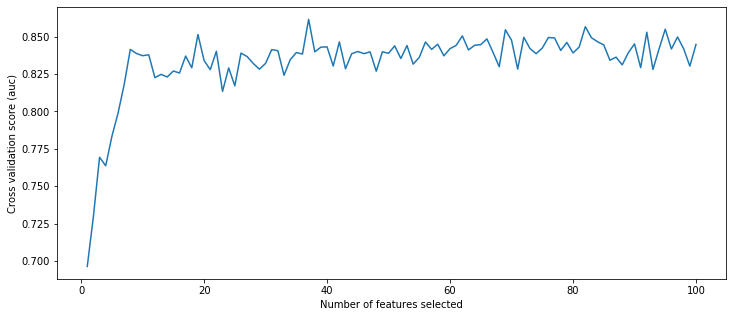

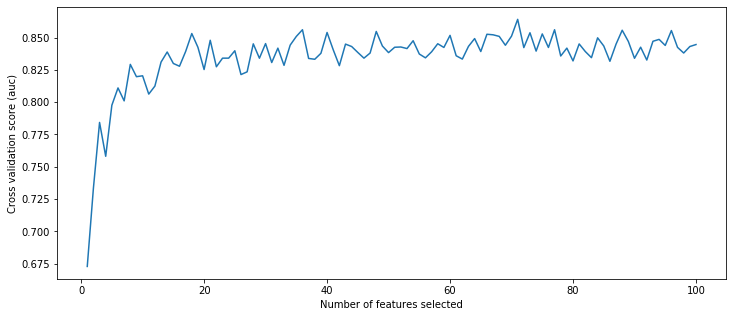

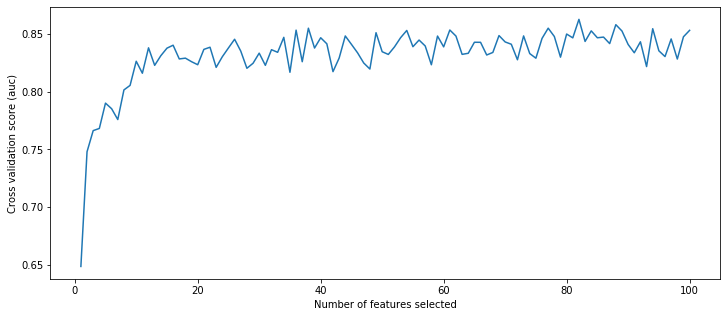

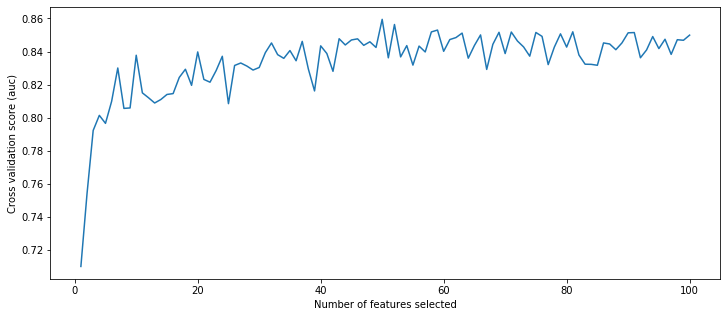

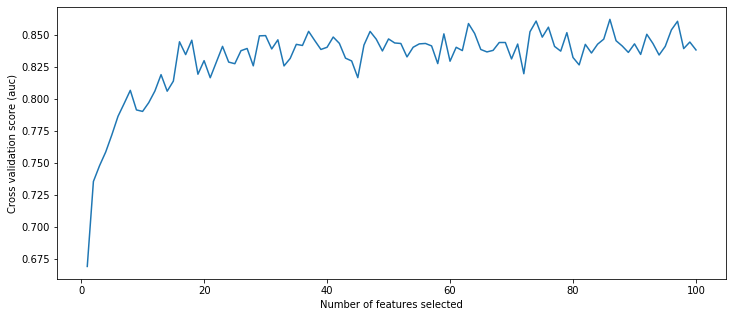

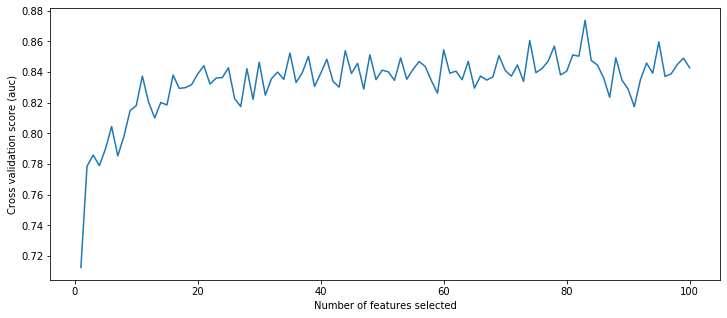

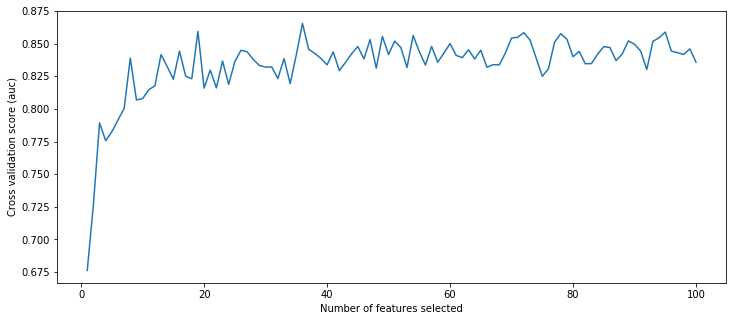

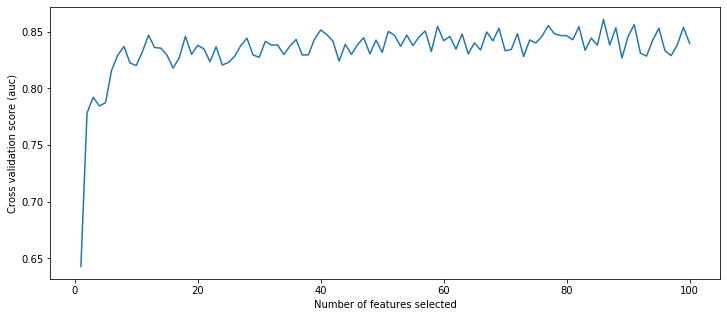

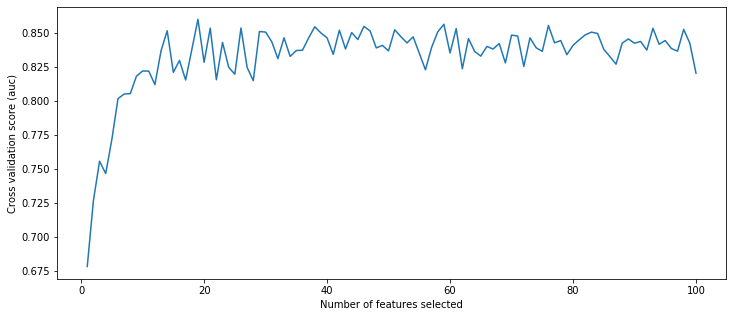

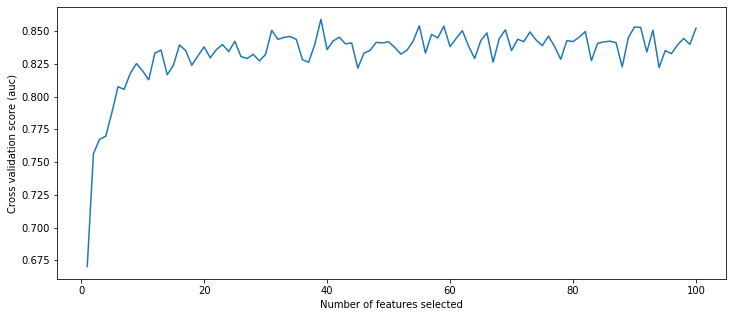

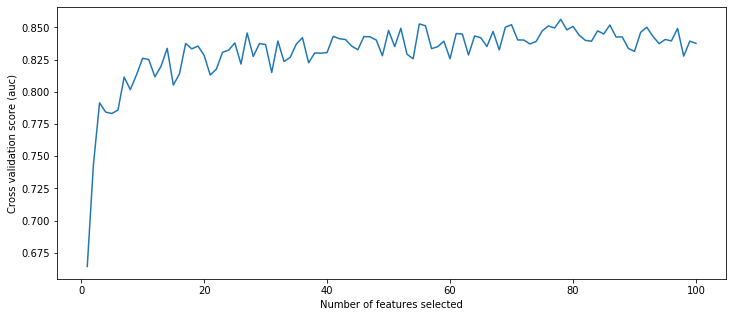

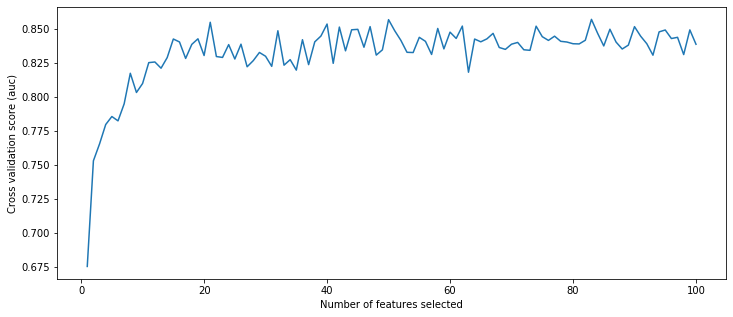

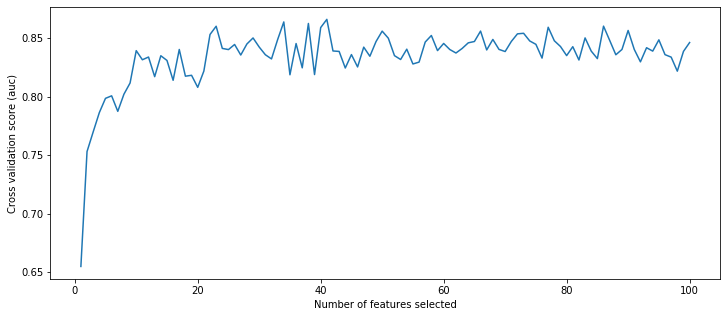

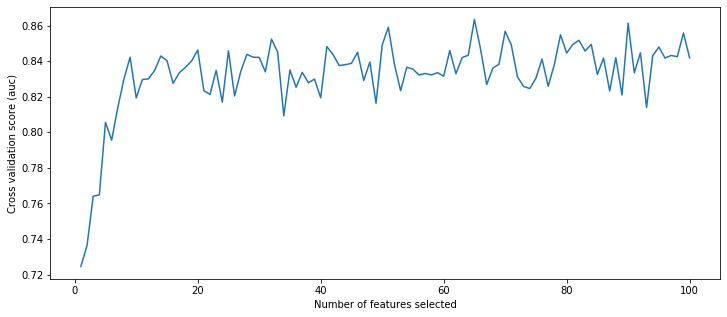

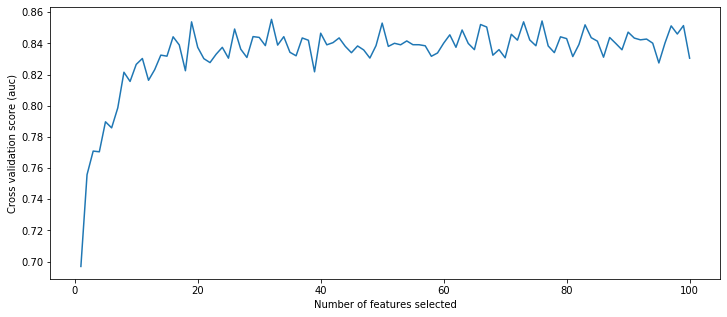

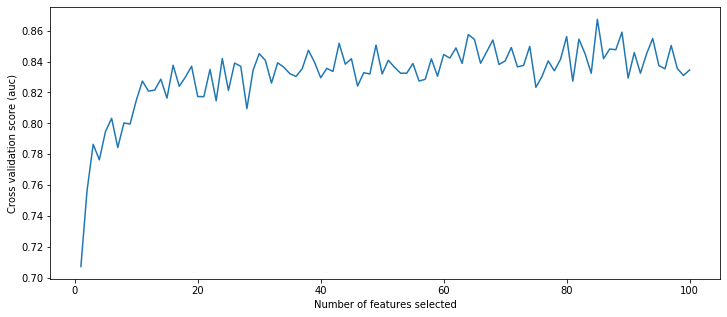

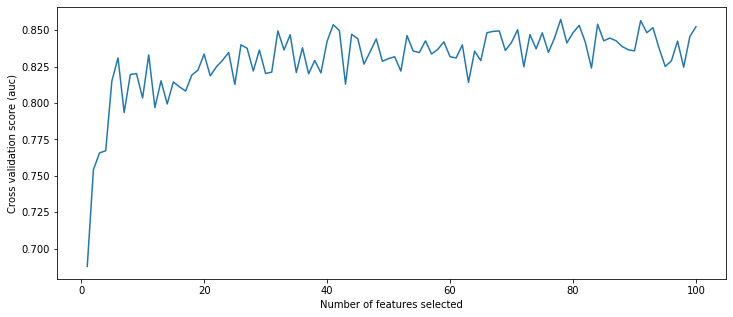

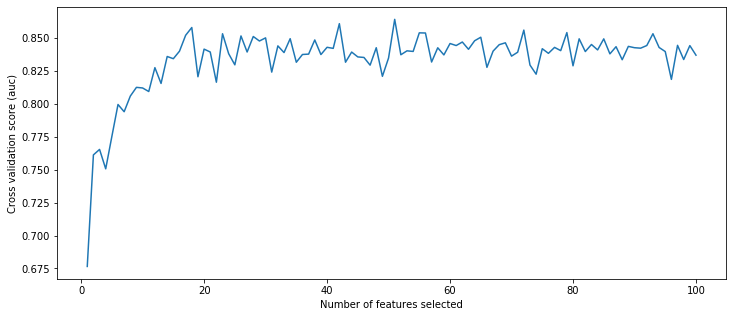

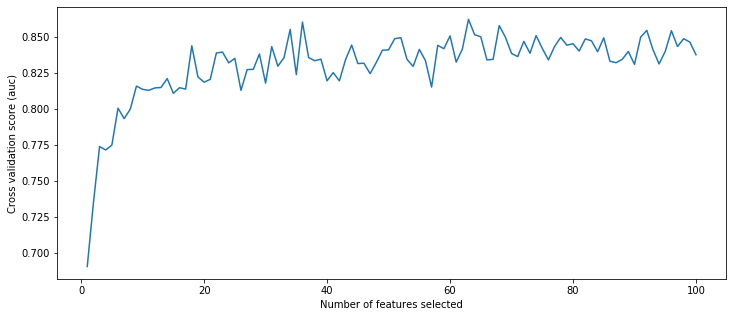

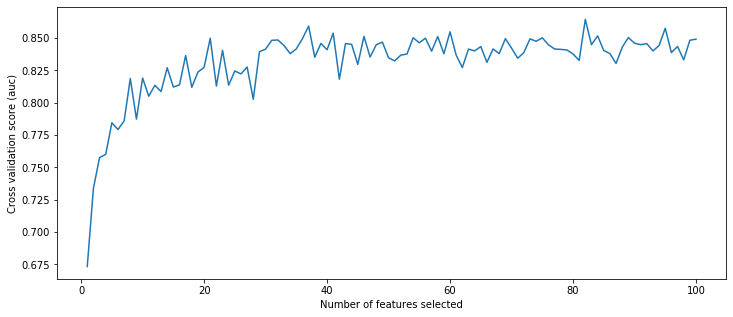

In [97]:
for i in range(1,21):
    plt.figure(figsize=(12,5))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (auc)")
    plt.plot(range(1, len(wrappers['rfecv_{}'.format(i)].grid_scores_) + 1), 
             wrappers['rfecv_{}'.format(i)].grid_scores_)
    plt.show()